<a href="https://colab.research.google.com/github/lxthames/style-transfer-latest/blob/main/style_transfer_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [ ]:
!pwd

/content/drive/My Drive


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.9 MB/s 


In [ ]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.3.1

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

In [ ]:
def scale_image(image):
    MAX_DIM = 512
    scale = np.max(image.shape)/MAX_DIM
    print(image.shape)
    new_shape = tf.cast(image.shape[:2]/scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    return image

In [ ]:
import cv2
auxImg=cv2.imread("/content/pexels-ketut-subiyanto-4803938.jpeg")
auxImg_1=cv2.imread("/content/pexels-ketut-subiyanto-4803938.jpeg")
auxImgRGB = cv2.cvtColor(auxImg, cv2.COLOR_BGR2RGB)
auxImgRGB_1 = cv2.cvtColor(auxImg_1, cv2.COLOR_BGR2RGB)



In [ ]:

#path_1 = "/content/output.png"
path_2 = "/content/Screen Shot 2022-08-15 at 7.32.16 PM.png"
#content_image = scale_image(np.asarray(Image.open("er.png")))
content_image = scale_image(np.asarray(auxImgRGB_1 ))
style_image = scale_image(np.asarray(auxImgRGB ))
#style_image = scale_image(np.asarray(Image.open(path_2)))
plt.figure(figsize=(10,8))
plt.imshow(content_image/255.)
plt.axis('off')
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(style_image/255.)
plt.axis('off')
plt.show()



In [ ]:
content_image.shape

TensorShape([498, 512, 3])

In [ ]:
class StyleTransferNetwork:
    def __init__(self, 
                 content_layers=None,
                 style_layers=None):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        default_content_layers = ['block5_conv1']
        default_style_layers = ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1', 
                        'block4_conv1', 
                        'block5_conv1']
        content_layers = content_layers if content_layers else default_content_layers
        style_layers = style_layers if style_layers else default_style_layers
        self.content_outputs = [vgg.get_layer(x).output for x in content_layers]
        self.style_outputs = [vgg.get_layer(x).output for x in style_layers]
        self.model = Model(vgg.input, [self.content_outputs, self.style_outputs])

        self.mse = tf.keras.losses.MeanSquaredError()
        
    def gram_matrix(self, x):
        x = tf.transpose(tf.squeeze(x), (2,0,1));
        x = tf.keras.backend.batch_flatten(x)
        num_points = x.shape[-1]
        gram = tf.linalg.matmul(x, tf.transpose(x))/num_points
        return gram

    def extract_features(self, inputs):
        image = tf.keras.applications.vgg19.preprocess_input(inputs*255.)
        contents, styles = self.model(image)
        styles = [self.gram_matrix(s) for s in styles]
        return contents, styles
    def calc_loss(self, y_true, y_pred):
      loss = [self.mse(x, y) for x, y in zip(y_pred, y_true)]
      return tf.reduce_mean(loss)
    
    #@tf.function
    def train_step(self, image, content_ref, style_ref):
        with tf.GradientTape() as tape:
            content_features, style_features = self.extract_features(image)
            content_loss = self.content_weight*self.calc_loss(content_ref, content_features)
            style_loss = self.style_weight*self.calc_loss(style_ref, style_features)
            loss = content_loss + style_loss

        grad = tape.gradient(loss, image)
        self.optimizer.apply_gradients([(grad, image)])
        image.assign(tf.clip_by_value(image, 0., 1.))
            
        return content_loss, style_loss    
                
    def train(self, content_image, style_image, steps, content_weight=1, style_weight=1e-5):
        self.style_weight = style_weight
        self.content_weight = content_weight
        
        content_image = tf.reverse(content_image, axis=[-1])
        style_image = tf.reverse(tf.image.resize(style_image, content_image.shape[:2]), axis=[-1])
        
        style_image = tf.cast(tf.expand_dims(style_image, 0), tf.float32)/255.
        content_image = tf.cast(tf.expand_dims(content_image, 0), tf.float32)/255.

        # get reference content and style features
        content_ref, _ = self.extract_features(content_image)
        _, style_ref = self.extract_features(style_image)

        self.optimizer = Adam(0.02,  beta_1=0.99, epsilon=1e-1)
        
        if content_weight==0 or style_weight==0:
            image = tf.Variable(tf.random.normal(shape=content_image.shape))
        else:
            image = tf.Variable(content_image)
        for i in range(1,steps+1):
            content_loss, style_loss = self.train_step(image, content_ref, style_ref)
            print(f"it is step no : {i}")
            if i%1000 == 0:
                print(f"Step {i} content_loss {content_loss:.4f} style_loss {style_loss:.4f}")
                plt.figure(figsize=(10,8))
                plt.imshow(tf.reverse(image[0],axis=[-1]))
                plt.axis('off')
                plt.savefig("output.png",dpi=300)
                plt.show()
                
        
        self.stylyzed = tf.cast(255.*tf.reverse(image[0],axis=[-1]), tf.uint8)
        return self.stylyzed

In [ ]:
stn = StyleTransferNetwork(content_layers=['block5_conv1'])
image = stn.train(content_image, style_image, steps=1000, content_weight=1, style_weight=0)

In [ ]:
stn = StyleTransferNetwork(style_layers=['block1_conv1'])
image = stn.train(content_image, style_image, steps=1000, content_weight=0, style_weight=1)

it is step no : 1
it is step no : 2
it is step no : 3
it is step no : 4
it is step no : 5
it is step no : 6
it is step no : 7
it is step no : 8
it is step no : 9
it is step no : 10
it is step no : 11
it is step no : 12
it is step no : 13
it is step no : 14
it is step no : 15
it is step no : 16
it is step no : 17
it is step no : 18
it is step no : 19
it is step no : 20
it is step no : 21
it is step no : 22
it is step no : 23
it is step no : 24
it is step no : 25
it is step no : 26
it is step no : 27
it is step no : 28
it is step no : 29
it is step no : 30
it is step no : 31
it is step no : 32
it is step no : 33
it is step no : 34
it is step no : 35
it is step no : 36
it is step no : 37
it is step no : 38
it is step no : 39
it is step no : 40
it is step no : 41
it is step no : 42
it is step no : 43
it is step no : 44
it is step no : 45
it is step no : 46
it is step no : 47
it is step no : 48
it is step no : 49
it is step no : 50
it is step no : 51
it is step no : 52
it is step no : 53
it

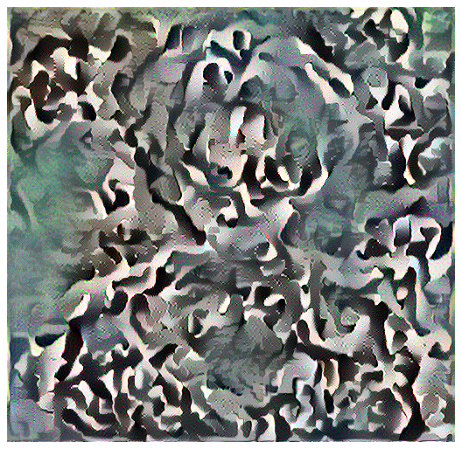

In [ ]:
stn = StyleTransferNetwork()
image = stn.train(content_image, style_image, steps=1000, content_weight=1., style_weight=1e-5)

In [ ]:
import cv2
image = cv2.imread("/content/er.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [ ]:
import cv2
image_2 = cv2.imread("/content/asd.png")
gray = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
backtorgb_1 = cv2.cvtColor(blurred ,cv2.COLOR_GRAY2RGB)

In [ ]:
wide = cv2.Canny(blurred, 0, 250)

In [ ]:
blurred.shape

(231, 341)

In [ ]:
backtorgb = cv2.cvtColor(blurred ,cv2.COLOR_GRAY2RGB)

In [ ]:
import numpy as np
import numpy.fft as fp
from scipy import signal
import scipy.fftpack
from skimage.io import imread
from skimage.color import rgb2gray 
from skimage.metrics import peak_signal_noise_ratio
from scipy.ndimage import convolve
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from skimage.filters import sobel, threshold_otsu
def dft2(im):
    
    freq = cv2.dft(np.float32(im), flags = cv2.DFT_COMPLEX_OUTPUT)
    freq_shift = np.fft.fftshift(freq)
    mag, phase = freq_shift[:,:,0], freq_shift[:,:,1]

    return mag + 1j*phase
def homomorphic_filter(im, D0, g_l=0, g_h=1, n=1):
    im_log = np.log(im.astype(np.float)+1)
    im_fft = dft2(im_log)
    H = (g_h - g_l) * butterworth(im.shape, D0, n) + g_l
    #H = np.fft.ifftshift(H)
    im_fft_filt = H*im_fft
    #im_fft_filt = np.fft.ifftshift(im_fft_filt)
    im_filt = idft2(im_fft_filt)
    im = np.exp(im_filt.real)-1
    im = np.uint8(255*im/im.max())
    return im
def idft2(freq):
    
    real, imag = freq.real, freq.imag
    back = cv2.merge([real, imag]) 
    back_ishift = np.fft.ifftshift(back)
    im = cv2.idft(back_ishift, flags=cv2.DFT_SCALE)
    im = cv2.magnitude(im[:,:,0], im[:,:,1])

    return im
def butterworth(sz, D0, n=1):
    h, w = sz
    u, v = np.meshgrid(range(-w//2,w//2), range(-h//2,h//2)) #, sparse=True)
    return 1 / (1 + (D0/(0.01+np.sqrt(u**2 + v**2)))**(2*n))
image = rgb2gray(imread('/content/asd.png'))
image_filtered = homomorphic_filter(image, D0=30, n=2, g_l=0.3, g_h=1)

image_edges = sobel(image)
image_edges = image_edges <= threshold_otsu(image_edges)

image_filtered_edges = sobel(image_filtered)
image_filtered_edges = image_filtered_edges <= threshold_otsu(image_filtered_edges)

#plt.figure(figsize=(21,17))
#plt.gray()
#plt.subplots_adjust(0,0,1,0.95,0.01,0.05)
#plt.subplot(221), plt.imshow(image), plt.axis('off'), plt.title('original image', size=20)
#plt.subplot(222), plt.imshow(image_filtered), plt.axis('off'), plt.title('filtered image', size=20)
#plt.subplot(223), plt.imshow(image_edges), plt.axis('off'), plt.title('original image edges', size=20)
#plt.subplot(224), plt.imshow(image_filtered_edges), plt.axis('off'), plt.title('filtered image edges', size=20)
#plt.savefig("output.png",dpi=400)
#plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
image_filtered_edges = sobel(image_filtered)

In [ ]:
#image_filtered_edges = image_filtered_edges <= threshold_otsu(image_filtered_edges)
plt.gray()
plt.figure(figsize=(12,8))
plt.imshow(image_filtered_edges/255.)
plt.axis('off')
plt.show()
#plt.savefig("output.png",dpi=500)

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')

import numpy as np
import matplotlib.pylab as plt
from PIL import Image, ImageFilter
from copy import deepcopy

def plot_image(image, title=None, sz=20):
    plt.imshow(image)
    plt.title(title, size=sz)
    plt.axis('off')

def add_noise(im, prop_noise, salt=True, pepper=True):
    im = deepcopy(im)
    n = int(im.width * im.height * prop_noise)
    x, y = np.random.randint(0, im.width, n), np.random.randint(0, im.height, n)
    for (x,y) in zip(x,y):
        im.putpixel((x, y),         # generate salt-and-pepper noise
        ((0,0,0) if np.random.rand() < 0.5 else (255,255,255)) if salt and pepper \
        else (255,255,255) if salt \
        else (0, 0, 0)) # if pepper
    return im

orig = Image.open('/content/asd.png')
i = 1
plt.figure(figsize=(12,35))
for prop_noise in np.linspace(0.05,0.3,6):
 # choose random locations inside image
 im = add_noise(orig, prop_noise)
 plt.subplot(6,2,i), plot_image(im, 'Original Image with ' + str(int(100*prop_noise)) + '% added noise')
 im1 = im.filter(ImageFilter.BLUR)
 plt.subplot(6,2,i+1), plot_image(im1, 'Blurred Image')
 i += 2

plt.show()